In [ ]:
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
import math
import IPython.display as display
import matplotlib.pyplot as plt
from PIL import Image
import os, sys, shutil
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.applications.imagenet_utils import decode_predictions
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

## EDA

In [ ]:
def readDatasetDF(datasetType, rootDir='data/'):
    """
    dataset Type: "train", "val", "test" 
    Return:
        dataframe with image name/label
    """
    df = pd.read_csv('{}/{}-calibrated-shuffled.txt'.format(rootDir, datasetType), header=None, delimiter = " ")
    df[0] = rootDir+"/"+df[0]
    return df

df_tr = readDatasetDF('train')
df_val = readDatasetDF('val')
df_test = readDatasetDF('test')
df_tr.head()

,0,1
0,data//calibrated/0077ML0005780000102730I01_DRC...,15
1,data//calibrated/0072MR0005610170103642E01_DRC...,8
2,data//calibrated/0069MR0004130000103477I01_DRC...,21
3,data//calibrated/0154ML0008510010104492E01_DRC...,8
4,data//calibrated/0019MR0000530000100138C00_DRC...,8


In [ ]:
print(df_tr.shape)
print(df_val.shape)
print(df_test.shape)

(3746, 2)
(1640, 2)
(1305, 2)


In [ ]:
df_tr[1].value_counts()

8     2343
9      224
23     178
21     166
10     165
14     101
15      85
17      73
24      69
20      57
3       47
5       36
13      36
12      32
0       30
4       19
16      18
2       15
11      14
19      12
7        8
18       8
1        6
6        4
Name: 1, dtype: int64

In [ ]:
class_names = pd.read_csv('data/msl_synset_words-indexed.txt', delimiter="      ", header=None, engine='python').set_index(0).to_dict()[1]
for i in class_names.keys():
    class_names[i] = class_names[i].strip()
class_names

{0: 'apxs',
 1: 'apxs cal target',
 2: 'chemcam cal target',
 3: 'chemin inlet open',
 4: 'drill',
 5: 'drill holes',
 6: 'drt front',
 7: 'drt side',
 8: 'ground',
 9: 'horizon',
 10: 'inlet',
 11: 'mahli',
 12: 'mahli cal target',
 13: 'mastcam',
 14: 'mastcam cal target',
 15: 'observation tray',
 16: 'portion box',
 17: 'portion tube',
 18: 'portion tube opening',
 19: 'rems uv sensor',
 20: 'rover rear deck',
 21: 'scoop',
 22: 'sun',
 23: 'turret',
 24: 'wheel'}

In [ ]:
df_tr[2] = df_tr[1].map(class_names)
df_val[2] = df_val[1].map(class_names)
df_test[2] = df_test[1].map(class_names)

In [ ]:
img_paths = df_tr.iloc[:, 0].tolist()
rootDir = 'msl-images/'
img = cv2.imread(img_paths[0])

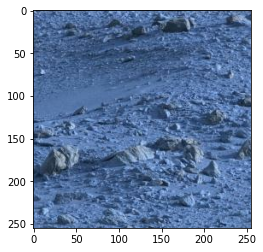

In [ ]:
img_paths = df_tr.loc[df_tr[1] == 8][0].iloc[0]
rootDir = 'msl-images/'
img = cv2.imread(img_paths)
plt.imshow(img)

## Preprocessing

In [ ]:
#Combine all datasets
frames = [df_tr, df_val, df_test]
result = pd.concat(frames)
result.reset_index(drop = True, inplace = True)

In [ ]:
#Split the data again
X = result[0]
Y = result[1]

X_train_temp, X_test, Y_train_temp, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1, stratify = Y)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_temp, Y_train_temp, test_size=0.25, random_state=1, stratify = Y_train_temp)

In [ ]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(4014,)
(1338,)
(1339,)


In [ ]:
train_df = pd.concat([X_train, Y_train], axis=1)
val_df = pd.concat([X_val, Y_val], axis=1)
test_df = pd.concat([X_test, Y_test], axis=1)

In [ ]:
#Check all classes are represented
print(sorted(train_df[1].unique()))
print(sorted(val_df[1].unique()))
print(sorted(test_df[1].unique()))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24]


In [ ]:
train_df.to_csv('data/train_df_new.txt', header=None, index=None, sep=' ', mode='w')
val_df.to_csv('data/val_df_new.txt', header=None, index=None, sep=' ', mode='w')
test_df.to_csv('data/test_df_new.txt', header=None, index=None, sep=' ', mode='w')

In [ ]:
#Prepare the dataset
batch_size = 32
img_height = 256
img_width = 256
path = 'data/'

train_dir = path + '/train_df_new.txt'
validation_dir = path + '/val_df_new.txt'
test_dir = path + '/test_df_new.txt'

def read_dataset(dir):
    df = pd.read_csv(dir, header=None, delimiter = " ")
    df[0] = df[0]
    image_paths = df[0].values
    labels = df[1].values
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    return dataset

train_ds = read_dataset(train_dir)
val_ds = read_dataset(validation_dir)
test_ds = read_dataset(test_dir)

def read_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [img_height, img_width])
    #image = (image / 255.0)
    return image, label 

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.map(read_image, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(read_image, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(read_image, num_parallel_calls=AUTOTUNE)

In [ ]:
def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)
test_ds =  configure_for_performance(test_ds)

## Base No pre-train model

In [ ]:
base_model = tf.keras.applications.ResNet50(
    include_top=False, input_shape=(256, 256, 3), weights='None'
)

In [ ]:
num_classes = 25

inputs = tf.keras.layers.Input([256, 256, 3])
x = base_model(inputs)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(25, activation="softmax")(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

# Compile the Model
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
initial_epochs = 20

history = model.fit(train_ds, epochs=initial_epochs, validation_data=val_ds)

In [ ]:
# Learning Curve
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,5.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Transfer Learning

In [ ]:
# Baseline Resnet50 model
base_model = tf.keras.applications.ResNet50(
    include_top=False, input_shape=(256, 256, 3), weights='imagenet'
)

In [ ]:
# Freeze the base
base_model.trainable = False

In [ ]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [ ]:
num_classes = 25

inputs = tf.keras.layers.Input([256, 256, 3])
x = base_model(inputs)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(25, activation="softmax")(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

# Compile the Model
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
initial_epochs = 5

history = model.fit(train_ds, epochs=initial_epochs, validation_data=val_ds)

Epoch 1/5


C:\Users\Home\anaconda3\envs\py36\lib\site-packages\keras\backend.py:4907: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


126/126 [==============================] - 238s 2s/step - loss: 0.3693 - accuracy: 0.9023 - val_loss: 0.0811 - val_accuracy: 0.9798
Epoch 2/5
126/126 [==============================] - 244s 2s/step - loss: 0.0554 - accuracy: 0.9851 - val_loss: 0.0402 - val_accuracy: 0.9888
Epoch 3/5
126/126 [==============================] - 241s 2s/step - loss: 0.0274 - accuracy: 0.9923 - val_loss: 0.0413 - val_accuracy: 0.9888
Epoch 4/5
126/126 [==============================] - 242s 2s/step - loss: 0.0237 - accuracy: 0.9923 - val_loss: 0.0273 - val_accuracy: 0.9910
Epoch 5/5
126/126 [==============================] - 240s 2s/step - loss: 0.0216 - accuracy: 0.9953 - val_loss: 0.0233 - val_accuracy: 0.9933


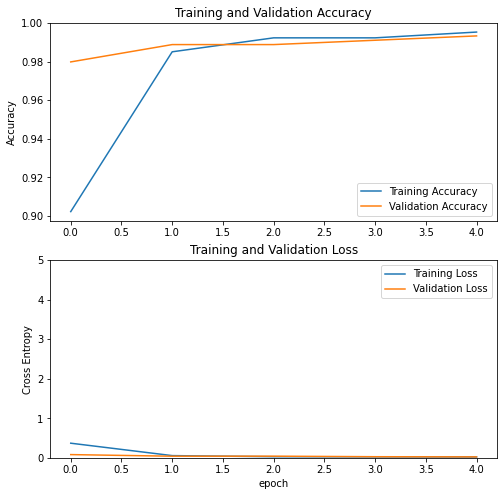

In [ ]:
# Learning CUrve
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,5.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
model.evaluate(test_ds)

42/42 [==============================] - 59s 1s/step - loss: 0.0626 - accuracy: 0.9813


[0.0626353770494461, 0.9813293218612671]

In [ ]:
def get_confusion_matrix(model, ds):
    all_predictions = np.array([])
    all_labels = np.array([])
    for x, y in ds:
        predictions = model.predict(x)
        predictions = np.argmax(predictions, axis = 1)
        all_predictions = np.concatenate([all_predictions, predictions])
        all_labels = np.concatenate([all_labels, y])
    return tf.math.confusion_matrix(all_predictions, all_labels)

In [ ]:
cf_matrix = get_confusion_matrix(model, test_ds)

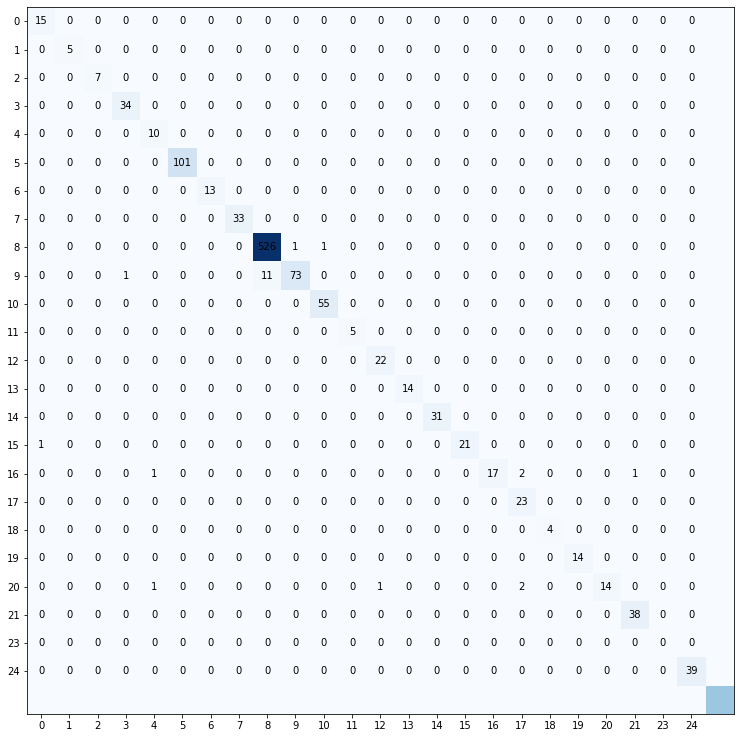

In [ ]:
plt.figure(figsize=(13,13))
plt.imshow(cf_matrix.numpy(), cmap=plt.cm.Blues)

for i in range(24):
    for j in range(24):
        c = cf_matrix.numpy()[j,i]
        plt.text(i, j, str(c), va='center', ha='center')

ax = plt.xticks(range(24), np.sort(test_df[1].unique()))
ax = plt.yticks(range(24), np.sort(test_df[1].unique()))

## Model with image augmentation

In [ ]:
RESIZE = 255
BATCH_SIZE = 32

In [ ]:
data_augmentation = tf.keras.Sequential([        
    tf.keras.layers.experimental.preprocessing.Rescaling(1./RESIZE),                          
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2)
])

In [ ]:
epochs = 100
input_shape = (256,256,3)
# Create base model
base_model = tf.keras.applications.ResNet50V2(
    input_shape=input_shape,
    include_top=False,
    weights="imagenet",
    pooling=None,
    classes=25,
    classifier_activation="softmax",
)
# Freeze base model
#base_model.trainable = False
base_model.trainable = True

fine_tune_at = 130

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

In [ ]:
# Create new model on top.
inputs = tf.keras.Input(shape=(256, 256, 3))
x = data_augmentation(inputs)
x = tf.keras.applications.resnet_v2.preprocess_input(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(25)(x)
model = tf.keras.Model(inputs, outputs)

base_learning_rate = 0.0001
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [ ]:
base_model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 130, 130, 64) 0           conv1_conv[0][0]                 
_________________________________________________________________________________________

In [ ]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  190


In [ ]:
lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", patience=3, min_lr=1e-6, mode='min')

In [ ]:
# fit_generator
history = model.fit(
    train_ds, 
    epochs= 5, 
    batch_size=BATCH_SIZE, 
    steps_per_epoch=None, 
    validation_data=val_ds, 
    validation_steps=None,
    callbacks=lr_reducer
) 

Epoch 1/5
695/695 [==============================] - 20208s 29s/step - loss: 0.0789 - accuracy: 0.9783 - val_loss: 0.0228 - val_accuracy: 0.9919
Epoch 2/5
695/695 [==============================] - 22835s 33s/step - loss: 0.0279 - accuracy: 0.9928 - val_loss: 0.1162 - val_accuracy: 0.9635
Epoch 3/5
695/695 [==============================] - 5727s 8s/step - loss: 0.0160 - accuracy: 0.9952 - val_loss: 0.0234 - val_accuracy: 0.9919
Epoch 4/5
695/695 [==============================] - 4353s 6s/step - loss: 8.4503e-04 - accuracy: 0.9995 - val_loss: 0.0490 - val_accuracy: 0.9919
Epoch 5/5
695/695 [==============================] - 57568s 83s/step - loss: 3.8865e-04 - accuracy: 0.9998 - val_loss: 0.0528 - val_accuracy: 0.9911


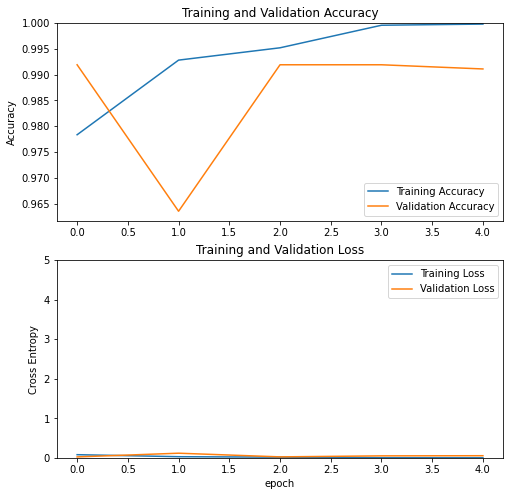

In [ ]:
# Learning CUrve
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,5.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
pred = model.predict(val_ds)
pred_class = np.argmax(pred, axis=1)

In [ ]:
test_label = np.concatenate([y for x, y in val_ds], axis=0)

In [ ]:
cf_matrix = confusion_matrix(test_label, pred_class)

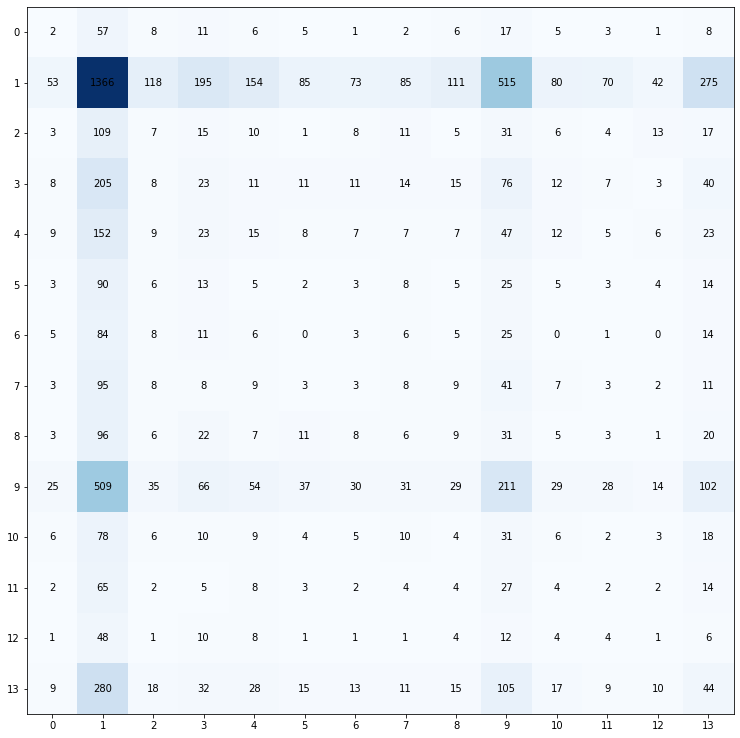

In [ ]:
plt.figure(figsize=(13,13))
plt.imshow(cf_matrix, cmap=plt.cm.Blues)

for i in range(24):
    for j in range(24):
        c = cf_matrix[j,i]
        plt.text(i, j, str(c), va='center', ha='center')

ax = plt.xticks(range(24), np.sort(test_df[1].unique()))
ax = plt.yticks(range(24), np.sort(test_df[1].unique()))

## Eliminating under-represented classes

The data has few under-sampled classes (under 80), we would like to remove them


In [ ]:
#omitted classes with less than 80 samples
omit = [0, 20, 19, 13, 6, 4, 2, 11, 1, 18]
omit_index = []
for index, row in result.iterrows():
    if row[1] in omit:
        omit_index.append(index)
        
result.drop([x for x in omit_index], inplace = True, axis = 0)
result.reset_index(drop = True, inplace = True)

In [ ]:
result.head(2)

,0,1,2
0,data//calibrated/0077ML0005780000102730I01_DRC...,15,observation tray
1,data//calibrated/0072MR0005610170103642E01_DRC...,8,ground


In [ ]:
#Map labels to new numbers
label_map = dict(zip(result[1].unique(), list(range(14))))
new_label_l = []
for x in result.itertuples():
    new_label_l.append(label_map[x[2]])
result[1] = new_label_l

In [ ]:
#Split the data again
X = result[0]
Y = result[1]

X_train_temp, X_test, Y_train_temp, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1, stratify = Y)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_temp, Y_train_temp, test_size=0.25, random_state=1, stratify = Y_train_temp)

In [ ]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(3702,)
(1234,)
(1235,)


In [ ]:
train_df = pd.concat([X_train, Y_train], axis=1)
val_df = pd.concat([X_val, Y_val], axis=1)
test_df = pd.concat([X_test, Y_test], axis=1)

In [ ]:
#Check all classes are represented
print(sorted(train_df[1].unique()))
print(sorted(val_df[1].unique()))
print(sorted(test_df[1].unique()))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]


In [ ]:
train_df.to_csv('data/train_df_no_under80.txt', header=None, index=None, sep=' ', mode='w')
val_df.to_csv('data/val_no_under80.txt', header=None, index=None, sep=' ', mode='w')
test_df.to_csv('data/test_no_under80.txt', header=None, index=None, sep=' ', mode='w')

In [ ]:
batch_size = 32
img_height = 256
img_width = 256
path = 'data/'

train_dir = path + '/train_df_no_under80.txt'
validation_dir = path + '/val_df_no_under80.txt'
test_dir = path + '/test_df_no_under80.txt'

def read_dataset(dir):
    df = pd.read_csv(dir, header=None, delimiter = " ")
    df[0] = df[0]
    image_paths = df[0].values
    labels = df[1].values
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    return dataset

train_ds = read_dataset(train_dir)
val_ds = read_dataset(validation_dir)
test_ds = read_dataset(test_dir)

def read_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [img_height, img_width])
    #image = (image / 255.0)
    return image, label 

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.map(read_image, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(read_image, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(read_image, num_parallel_calls=AUTOTUNE)

In [ ]:
def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)
test_ds =  configure_for_performance(test_ds)

### Rerun the model with image augmetation

In [ ]:
RESIZE = 255
BATCH_SIZE = 32

In [ ]:
data_augmentation = tf.keras.Sequential([        
    tf.keras.layers.experimental.preprocessing.Rescaling(1./RESIZE),                          
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2)
])

In [ ]:
epochs = 100
input_shape = (256,256,3)
# Create base model
base_model = tf.keras.applications.ResNet50V2(
    input_shape=input_shape,
    include_top=False,
    weights="imagenet",
    pooling=None,
    classes=25,
    classifier_activation="softmax",
)
# Freeze base model
#base_model.trainable = False
base_model.trainable = True

fine_tune_at = 130

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

In [ ]:
# Create new model on top.
inputs = tf.keras.Input(shape=(256, 256, 3))
x = data_augmentation(inputs)
x = tf.keras.applications.resnet_v2.preprocess_input(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(25)(x)
model = tf.keras.Model(inputs, outputs)

base_learning_rate = 0.0001
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [ ]:
base_model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 130, 130, 64) 0           conv1_conv[0][0]                 
_________________________________________________________________________________________

In [ ]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  190


In [ ]:
lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", patience=3, min_lr=1e-6, mode='min')

In [ ]:
# fit_generator
history = model.fit(
    train_ds, 
    epochs= 5, 
    batch_size=BATCH_SIZE, 
    steps_per_epoch=None, 
    validation_data=val_ds, 
    validation_steps=None,
    callbacks=lr_reducer
) 

Epoch 1/5
695/695 [==============================] - 20208s 29s/step - loss: 0.0789 - accuracy: 0.9783 - val_loss: 0.0228 - val_accuracy: 0.9919
Epoch 2/5
695/695 [==============================] - 22835s 33s/step - loss: 0.0279 - accuracy: 0.9928 - val_loss: 0.1162 - val_accuracy: 0.9635
Epoch 3/5
695/695 [==============================] - 5727s 8s/step - loss: 0.0160 - accuracy: 0.9952 - val_loss: 0.0234 - val_accuracy: 0.9919
Epoch 4/5
695/695 [==============================] - 4353s 6s/step - loss: 8.4503e-04 - accuracy: 0.9995 - val_loss: 0.0490 - val_accuracy: 0.9919
Epoch 5/5
695/695 [==============================] - 57568s 83s/step - loss: 3.8865e-04 - accuracy: 0.9998 - val_loss: 0.0528 - val_accuracy: 0.9911


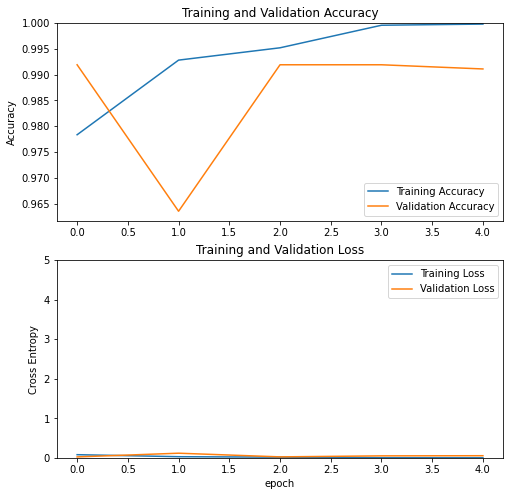

In [ ]:
# Learning CUrve
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,5.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
pred = model.predict(val_ds)
pred_class = np.argmax(pred, axis=1)

In [ ]:
test_label = np.concatenate([y for x, y in val_ds], axis=0)

In [ ]:
cf_matrix = confusion_matrix(test_label, pred_class)

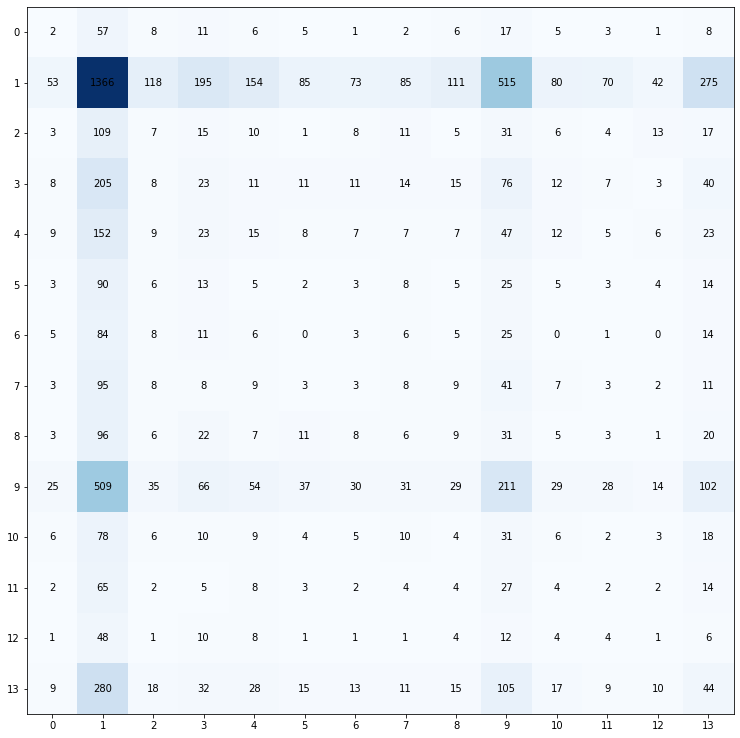

In [ ]:
plt.figure(figsize=(13,13))
plt.imshow(cf_matrix, cmap=plt.cm.Blues)

for i in range(24):
    for j in range(24):
        c = cf_matrix[j,i]
        plt.text(i, j, str(c), va='center', ha='center')

ax = plt.xticks(range(24), np.sort(test_df[1].unique()))
ax = plt.yticks(range(24), np.sort(test_df[1].unique()))